# Exercise 4
In this exercise, we will control a 2D drone depicted in the figure below <br>
<img src='quadrotor.png' width="300">

Consider the following simplified linear model of the drone
$$\begin{align}
    x_{n+1} = A
    x_n + B u_n
\end{align}$$

where the components of the state $x_n$ correspond to the horizontal position and velocity of the quadrotor, its vertical position and velocity and its orientation and angular velocity. The control vector
$u_n$ contains the forces produced by the rotors (our control inputs).
The module ```quadrotor.py``` defines the matrices $A$ and $B$ and code to generate a simulation of the drone.

In [2]:
## what we need to do computation and display the drone
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import quadrotor

In [2]:
# the matrices A and B are already defined in the quadrotor module
print(f'A =\n {quadrotor.A}')
print(f'B =\n {quadrotor.B}')


A =
 [[ 1.      0.01    0.      0.      0.      0.    ]
 [ 0.      1.      0.      0.     -0.0981  0.    ]
 [ 0.      0.      1.      0.01    0.      0.    ]
 [ 0.      0.      0.      1.      0.      0.    ]
 [ 0.      0.      0.      0.      1.      0.01  ]
 [ 0.      0.      0.      0.      0.      1.    ]]
B =
 [[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.02   0.02 ]
 [ 0.     0.   ]
 [ 0.015 -0.015]]


We want to generate a control input will move the drone towards the point $(3,3)$ starting from $(0,0)$. In order to
do so, we define a cost that penalizes the distance to the goal at each time step while minimizing velocities and the amount of trust needed,
i.e. we want to solve the following optimal control problem
$$\begin{align}
&\min_{x_0, u_0, x_1, u_1, \cdots} \frac{1}{2}\sum_{n=0}^{N} (x_n - x_{desired})^T Q (x_n - x_{desired}) + u_n^T R u_n\\
\textrm{subject to}\ \ & x_{n+1} = A x_{n} + B u_n\\
& x_0 = [0,0,0,0,0,0]^T
\end{align}$$
where $x_{desired} = [3,0,3,0,0,0]^T$

1. Write down the KKT conditions for the problem
2. Write code to solve the problem for N=500 time steps (you will need to find diagonal matrices $Q>0$ and $R>0$ to create a nice movement) by solving the KKT system of linear equations. Do NOT inverse the KKT matrix, instead use the [NumPy solve function](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) which is numerically more stable and efficient.
4. Show plots of all the states of the robot as a function of time
5. Show plots of the optimal control as a function of time

### Part 1
The gievn problem can be written in the form of 
$$
\min_{y} \frac{1}{2} y^T G y
$$
subject to 
$$
M y = p
$$

Now the Lagrangian can be written as 
$$
L(y, \lambda) = \frac{1}{2} y^T G y + \lambda^T (M y - p)
$$
The KKT conditons are then
$$

\nabla_x L = Gy +M^T\lambda = 0 \\
\nabla_\lambda L = My-p=0 \\
$$
Or Equivalently
$$
% \text{Or} \quad 
\begin{bmatrix}
G & M^T \\
M & 0
\end{bmatrix}
\begin{pmatrix}
y \\
\lambda
\end{pmatrix}
=
\begin{pmatrix}
0 \\
p
\end{pmatrix}
$$
where
$$
\text{Where, } G =
\begin{bmatrix}
Q & 0 & 0 & 0 & 0 & \cdots \\
0 & R & 0 & 0 & 0 & \cdots \\
0 & 0 & Q & 0 & 0 & \cdots \\
0 & 0 & 0 & R & 0 & \cdots \\
0 & 0 & 0 & 0 & 0 & \cdots
\end{bmatrix}
\quad
\newline
y =
\begin{bmatrix}
x_0 - x_{\text{desired}} \\
u_0 \\
x_1 - x_{\text{desired}} \\
u_1 \\
\vdots
\end{bmatrix}
\quad
\newline
M =
\begin{bmatrix}
I & 0 & 0 & 0 & 0 & 0 & \cdots \\
A & B & -I & 0 & 0 & 0 & \cdots \\
0 & 0 & A & B & -I & 0 & \cdots \\
0 & 0 & 0 & 0 & A & B & \cdots \\
0 & 0 & 0 & 0 & 0 & 0 & \cdots
\end{bmatrix}
\quad
\newline
p =
\begin{bmatrix}
x_0 \\
0 \\
0 \\
0 \\
\vdots
\end{bmatrix}
$$





In [3]:
# # we define a few constants
# xdim = 6 # dimension of the state (p,v)
# udim = 2 # dimension of the control (u)
# N = 500 # number of steps
# nvars = N*udim + (N+2)*xdim # total number of variables
# dt = 0.01 #delta t
# # we define the desired coordinates
# desired_coordinates = np.array([3,3])

# ## We define the cost
# Q = np.eye(xdim)
# Q[0,0] = Q[2,2] = Q[4,4] = 10.  # position penalty
# Q[1,1] = Q[3,3] = Q[5,5] = 5.   # velocity penalty
# R = np.eye(udim) * 0.01

# # Placeholder Matrix for the cost to go
# P_n = np.zeros((N, xdim, xdim))
# # Since we are computing from back 
# P_n[N-1] = Q
# # Feedback matrix
# K = np.zeros((N, udim, xdim))
# # State and control inputs 
# u = np.zeros((udim, N))  
# x = np.zeros((xdim, N))  
# # Desired State
# x_desired = np.array([desired_coordinates[0], 0, desired_coordinates[1], 0, 0, 0])

# # Backward pass
# for i in range(N-2, 0, -1):
#     K_B = R + quadrotor.B.T @ P_n[i+1] @ quadrotor.B
#     K_A = quadrotor.B.T @ P_n[i+1] @ quadrotor.A
#     # Solve for K_n+1
#     K[i+1] = np.linalg.solve(K_B, K_A)
#     # Update cost-to-go matrix
#     P_n[i] = Q + quadrotor.A.T @ P_n[i+1] @ quadrotor.A - \
#         quadrotor.A.T @ P_n[i+1] @ quadrotor.B @ K[i+1]
# print(Q)
# # Forward pass:
# for i in range(0, N-1, 1):
#     # Compute the control input
#     u[:, i] = -K[i] @ (x[:, i] - x_desired)
#     # Update the state of the drone
#     x[:, (i+1)] = quadrotor.A @ x[:, i] + quadrotor.B @ u[:, i]




In [7]:
# Parameters
N = 500
des_state = np.array([3,0,3,0,0,0,0,0]).reshape(-1,1)
Q = np.identity(6)
Q[0,0] = Q[2,2] = Q[4,4] = 100.  # position penalty
Q[1,1] = Q[3,3] = Q[5,5] = 50.   # velocity penalty
R = np.identity(2) * 0.01

# Fill the G Matrix
G = np.zeros((8*N + 6, 8*N + 6))
G[-6:, -6:] = Q
mini_G = np.block([[Q, np.zeros((6, 2))], [np.zeros((2, 6)), R]])
for i in np.arange(0, 8*N, 8):
    G[i:i+8, i:i+8] = mini_G  # Fill G blocks




# Fill the M matrix
M = np.zeros((6*(N+1), 8*N + 6))  # Fixing the dimensions of M
mini_M = np.block([[-np.eye(6), np.zeros((6, 2))], [quadrotor.A, quadrotor.B]])  # Define mini_M correctly
# print(M.shape)

j = 0
for i in np.arange(0, 8*N, 8):
    M[j:(j+12), i:(i+8)] = mini_M  # Assign the mini_M block to M
    j += 6  # Increment by 6 for the next block

# Set the initial condition and final block in M
M[0:6, 0:6] = np.identity(6)
M[-6:, -6:] = -np.identity(6)



# print(M)
# Define p and ydes vectors
p = np.zeros((6*(N+1), 1))
ydes = np.block([[np.kron(np.ones((N, 1)), des_state)], [des_state[0:6]]])

# Compute G_des and solve
G_des = np.matmul(G, ydes)

Alin = np.block([[G, M.transpose()], [M, np.zeros((6*(N+1), 6*(N+1)))]])
blin = np.block([[G_des], [p]])

# Solve the system
yl = np.linalg.solve(Alin, blin)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMWltZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EVxliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BoAJ0/deNlxATljGKOZAuIjme27NfsYhAbFOlewDRF4IfKNDMH4Fv/q9RH8BCnmQCtkOmDFO5FsH
C/gh+ENzqQrfd3lpmJFLa+MNDKZs3fAjY20pX6A+EXDineinS/1R3baEFsSXbbf6hIVmeXqGcaP8
VTwxCrdyHWvaBrDj1N+wdZ3pbWsr21bD30HrNIAH3L9fLqY22RMX0uNu261iN63x3534+dC3oilR
IMhd1P2Q6MqAEXXQxeR3yCjnJEN+hp+qeLUJsvuK43U8CXKIfy/TrX2TfrQbEbHQzcoirKEIlUTN
dH3si1OP3VjXa345J8c/x/JrUJ1COOAkTYQh/g0Md8oYnS+vnPhlhAagjUfdVaxUYXy4l2q/R/5l
afLwxI/GwZkNjFvV5RRFMf8TYOmXXDerAQT0iOnQ/jkCYwBLPh+WpK5XwGi6L7OXu6DxniZwe4cs
w745kn8a3SEAvvQjthb/yaSMdKtge/4QBnwXr3A3Xdg6+hmXh9nMHqqVnfJlmB4yQPqqPylZBr/X
kKF083a9iqfKs+I5u1w1yJMtqCntDPK2PcgyeZwZHySWFO/9kehkkD5vysmOLwZQ7t7qwPM9x8vf
5Gdp66p19IiiawVCnhh0J4+noZQ0iBq0BfU39IjY/gntoB7Ux1LOhHAmMDRyXWwfRB3Iy4fcCjSX
FXOEeZnR8lafjD9vH8k9D8fLPo6iF3CVxdFZQ9nxhKz/oVj9IbWVyfRqOHYBpVocg/dK1b//py5E
hV7J3Khe9QAVmRr2jAwJ4NgRUWhtuvVdMkkPJehIcAV9uZCH+wC5UYvsmVyDviHLjUd50jyPwr2U
LISQ3ajW3fp1Ya3O/A2MNwlbP10yp1FQKxpDr+hWuVIe77nf9A/YIHWXFnDK7P8ZS6OeKNTkjaS9
jRDUIgGIWyTpKCxSmzv5OXhvjzuyJGaSXlQIIKPZf3yXQ6NE64jGQIPXdTxFt5Z3WuTMNlJxEB+r
yxxKaqPHRiohI1JjIBNxUVa+SJvR7o0b/TL3m+hZE9u/F8p+1355UXVjoH51LZ5F6GDOYaGD1TcT
TgxTrRp77khzxvNYEpeqS2M7nUiDoFmwAAwQ6Z6oktHMcK4sPcJXZIw1GKRbIIYvRH5Ghk/CzsT9
gN18ny/zadw4lT8RhFaV7irRCHsWKq7H6IHCPO97qWr+3NsZevBrgvqq9TKxsLBvo+cAmO+9lUvk
e8DHDBIzZ4DfTAgkSZAM5fP0W/69KtB+WRuB5WaMGp/SefYgVUE8iTqfGXN2oyfIMyjXYPVGc2+K
1DWrhxHYDb49VW88jt08oJLLk90b1oB99u8OtS2yISinXDOEwAzsMeAoneNGGSVcqg1T4u1gmnpy
iF9TI5ut8pPNcqEKFJ3JBXCVKQ6Hda3pqqf9XuUIcnKBoclZ5UL3dkzCAdRxtogJNXWXm/4UI5bz
fThjqb7uFiwERPN4WMwEkkF/gA5jLxlsP36uqJcHkUzMy5JYza4ImzMAnr7Jrf0moXfkqkIFn4pu
kWEYy3At4UMu1U/cZmBS2NDACL5XLJp4sX8DtAAAAwAAAwABxkuPGultmdb5gRVsvngT+/DcV05C
sOYuNjUsHMeoApCxZXeYOxqDcMWcL3tTr9de/r4oDRrJLi1EBEveqcjnuDsuK2uqeIEZgQ4+vXOC
l2RsWWyVBf1Z017ioyu8HfZVPE9fmXUTQwtCCRGVRCzU2yrnYsw3KcDMCpcJ9qSt1QEvWjlMUYsw
smSpbm5MREwjY4bC+EItvuWBcFdMauDT+qiwW0eYig4JJuCp+hZMZQfZu+a3hx8BO9O7KFvHoX+j
fM2en5PdouC2+3f/1LtIONFEZE8hzl6a8OZlZcJMebMK9NVxxsEIv3dkXSBaoxKMrg/zzh4oEiPc
bNwTAD7bpxH8osLsDOZyBGBR/rQv0u8sXby4o/gAAB5+tjUtvE+ZGGewAwtezrJvym2B6poRn2pJ
IGI5fwKmEvn089qZpZh1dOTUCrckb4T7bbldWzsAxM//3DJxVHVTlRjl8f5c6AE2CpG8B6SeUuhT
DAvoiOWttnplBKg+PvnQzfIaDnPsG+Ckgf+9c8Ful+r901OGfX4+7e1EmQRz+md0WPocbw5WZkHX
nFRYGKyH3wRz8tqYmmdFV7uE69T1l7mGoMpv24o9hfEadUmr9P+RjJ3ud2PLy2qd5Tm885eeVZHQ
V2SCr1OK0RtG4mncHY3K6HKH1CprebSCv/3Gzod3GFl1PacmSHVWVM0Eh0MCBziG/MzVXmz4tziv
iA4H8R+g5LJQgfR9Rp8RsixWpEUzAIPCPN+B1H9v1+896/t6ug3VFP89M3pXncjq8ZcKT430A5rm
iP/I7E7c+r97/kfEU/fgJw377rYUNJfzmsfju5lrv46WB7z6yzpDhpbhXfQ8C4mUUHHP2rxMylzk
o9lsm+UJz6LbLXRZy2h93aoIIwp5vHSM0fELX7ugKplhfCq7aGxc8oV1hyK02HpQs0YFBsvj6sRF
Eq22r/4WPonzoID/ht5VaNCJwtSCMhGGL0cAL7ztXjrZJ85Pq8EAmPZDV8CdVmkBzLh6In4RS+DK
KmL3YDLdAadN9yGF0z/DEpbVSTnOmKu22LNOYjb/zuLQtuI9htx4uKYtMdMfuklDiC1wLWf3KTCz
TAFvdMmMDvyeq2jdKuHdm/GrWKNZ7e0Td4xFzq0GTYC738QN2NrAuqvPQlbRASmVWwwY2QOUZFPq
G9Ae2mF4/DuZ51Qkm5qj+8CdPJhKKo/+PNmDQjiI1+TMD16pkCh8U2QPYE8Lqw0+AVPrRmR4OW6E
6MuePF2ncHHPagN+KSDaQ

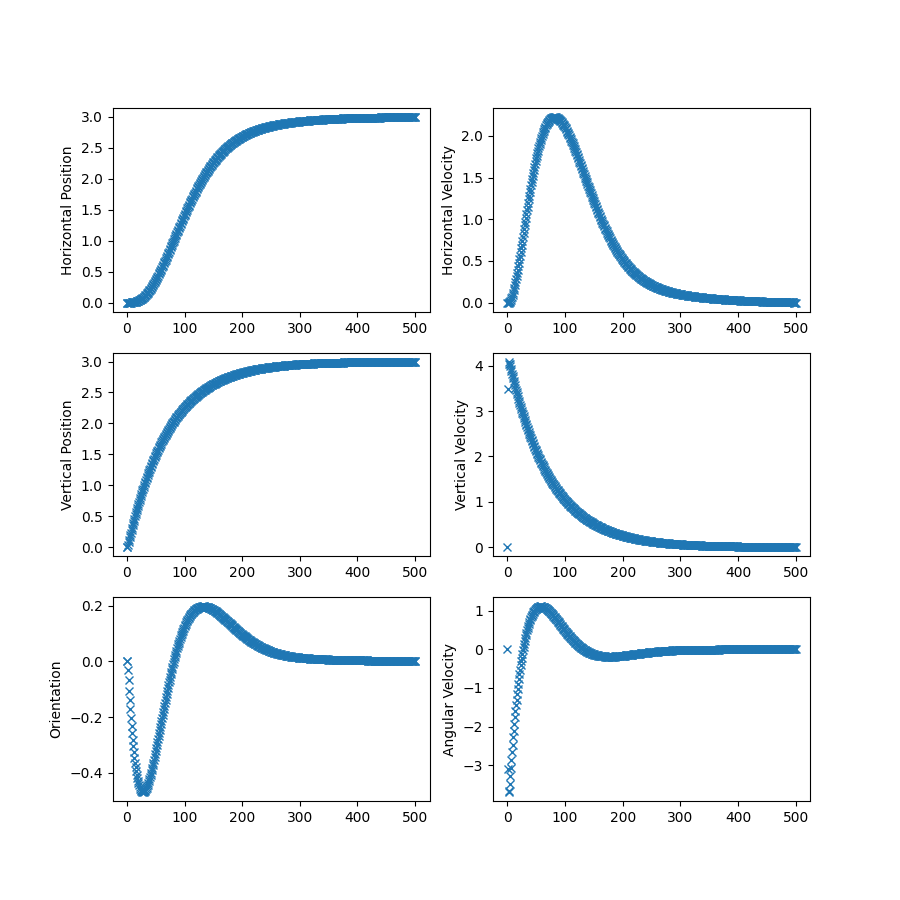

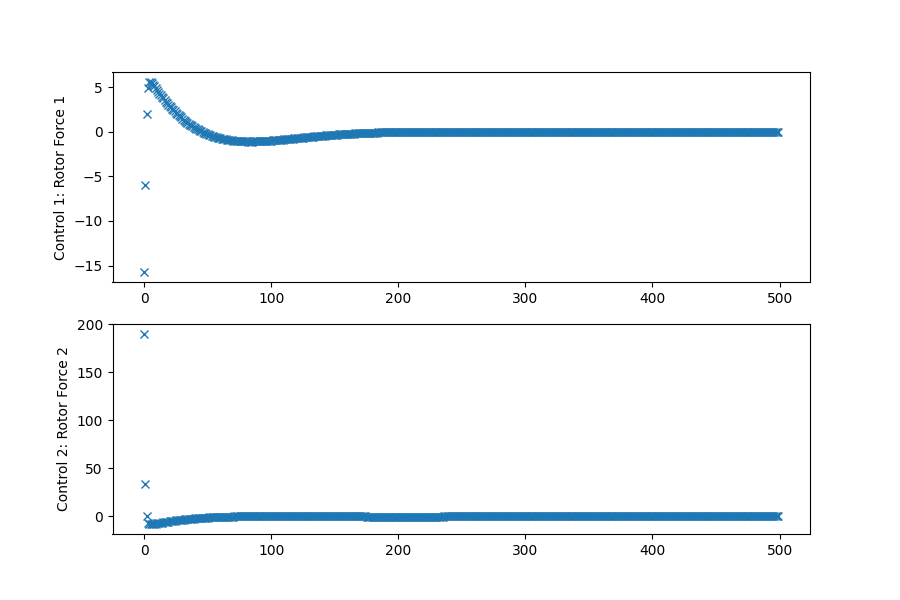

In [8]:
x_pos = yl[0:N*8+6:8].flatten()
x_vel = yl[1:N*8+6:8].flatten()
y_pos = yl[2:N*8+6:8].flatten()
y_vel = yl[3:N*8+6:8].flatten()
angle = yl[4:N*8+6:8].flatten()
angle_vel = yl[5:N*8+6:8].flatten()
control1 = yl[6:N*8+6:8].flatten()
control2 = yl[7:N*8+6:8].flatten()

x0 = np.array([
    x_pos,      # Shape: (501,)
    x_vel,      # Shape: (501,)
    y_pos,      # Shape: (501,)
    y_vel,      # Shape: (501,)
    angle,      # Shape: (501,)
    angle_vel   # Shape: (501,)
])

# print(f"x0 shape: {x0.shape}")  # Should output: (6, 501)

u = np.vstack([
    control1.flatten(),
    control2.flatten()
])  # Shape: (2, 500)

u = np.hstack([u, np.zeros((2, 1))])  # Shape: (2, 501)

plt.figure(figsize=[9,9])
plt.subplot(3,2,1)
plt.ylabel('Horizontal Position')
plt.plot(x_pos, 'x')
plt.subplot(3,2,2)
plt.ylabel('Horizontal Velocity')
plt.plot(x_vel, 'x')
plt.subplot(3,2,3)
plt.ylabel('Vertical Position')
plt.plot(y_pos, 'x')
plt.subplot(3,2,4)
plt.ylabel('Vertical Velocity')
plt.plot(y_vel, 'x')
plt.subplot(3,2,5)
plt.ylabel('Orientation')
plt.plot(angle, 'x')
plt.subplot(3,2,6)
plt.ylabel('Angular Velocity')
plt.plot(angle_vel, 'x')

plt.figure(figsize=[9,6])
plt.subplot(2,1,1)
plt.plot(control1, 'x')
plt.ylabel('Control 1: Rotor Force 1')
plt.subplot(2,1,2)
plt.plot(control2, 'x')
plt.ylabel('Control 2: Rotor Force 2')

# Optionally, animate the robot's movement (this requires the quadrotor animation function)
quadrotor.animate_robot(x0, np.array([control1, control2]), goal=[3, 3])  